# Retrieval Augumented Generation (RAG) inference

***This notebook works best with the `conda_python3` on the `ml.t3.large` instance***.

---

At this point our slide deck data is ingested into Amazon OpenSearch Service Serverless collection. We are now ready to talk to our slide deck using a large multimodal model. We are using the [Anthropic’s Claude 3 Sonnet foundation model](https://aws.amazon.com/about-aws/whats-new/2024/03/anthropics-claude-3-sonnet-model-amazon-bedrock/) for this purpose.

## Step 1. Setup

Install the required Python packages and import the relevant files.

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

  Cloning https://github.com/haotian-liu/LLaVA.git (to revision v1.1.1) to /tmp/pip-req-build-njkpwxux
  Running command git clone --filter=blob:none --quiet https://github.com/haotian-liu/LLaVA.git /tmp/pip-req-build-njkpwxux
  Running command git checkout -q 1619889c712e347be1cb4f78ec66e7cf414ac1a6
  Resolved https://github.com/haotian-liu/LLaVA.git to commit 1619889c712e347be1cb4f78ec66e7cf414ac1a6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import io
import sys
import json
import glob
import boto3
import base64
import logging
import requests
import botocore
import sagemaker
import numpy as np
import pandas as pd
import globals as g
from PIL import Image
from pathlib import Path
from typing import List, Dict
from IPython.display import Image
from urllib.parse import urlparse
from botocore.auth import SigV4Auth
from pandas.core.series import Series
from sagemaker import get_execution_role
from botocore.awsrequest import AWSRequest
from utils import get_cfn_outputs, get_text_embedding, get_llm_response
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
!pygmentize globals.py

"""
Global variables used throughout the code.
"""
import os
import boto3
import sagemaker

# model deployment
HF_MODEL_ID: str = "liuhaotian/llava-v1.5-13b"
LLM_ENGINE: str = "deepspeed"

# HF_TASK: str = "question-answering"
# TRANSFORMERS_VERSION: str = "4.28.1"
# PYTORCH_VERSION: str = "2.0.0"
# PYTHON_VERSION: str = "py310"

# S3 bucket strucutre, we use the default sagemaker bucket in the current region
# BUCKET_NAME: str = sagemaker.Session().default_bucket()
BUCKET_PREFIX: str = "multimodal"
BUCKET_EMB_PREFIX: str = f"{BUCKET_PREFIX}/osi-embeddings-json"
BUCKET_IMG_PREFIX: str = f"{BUCKET_PREFIX}/img"
LLAVA_PROMPT_PREFIX: str = 'multimodal/llavaPrompt/'

S3_MODEL_CODE_PREFIX: str = "code"
S3_MODEL_PREFIX: str = "model"

# Amazon Titan multimodal model
AWS_REGION: str = boto3.Session().region_name
FMC_URL: str = f"https://bedrock-runtime.{AWS_REGION}.amazonaws.com"
FMC_MODEL_ID: str = "amazon.titan-embed-text-v1"
CLAUDE_MODEL_ID: str = "anthropic.claude-3-sonnet-20240229-v1:0"
A

In [4]:
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

## Step 2. Create an OpenSearch client and SageMaker Predictor object

We create an OpenSearch client so that we can query the vector database for embeddings (slides) similar to the questions that we might want to ask of our slide deck and then we create a SageMaker [`Predictor`](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html) to run inference using the LLaVA model given the slide we retrieved from OpenSearch.

Get the name of the OpenSearch Service Serverless collection endpoint and index name from the CloudFormation stack outputs.

In [5]:
outputs = get_cfn_outputs(g.CFN_STACK_NAME)
host = outputs['MultimodalCollectionEndpoint'].split('//')[1]
index_name = outputs['OpenSearchIndexName']
logger.info(f"opensearchhost={host}, index={index_name}")


[2024-03-15 19:21:20,755] p31817 {1663180104.py:4} INFO - opensearchhost=dkubp87d98zgk2ir1t85.us-east-1.aoss.amazonaws.com, index=slides


In [6]:
session = boto3.Session()
credentials = session.get_credentials()
auth = AWSV4SignerAuth(credentials, g.AWS_REGION, g.OS_SERVICE)

os_client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20
)

[2024-03-15 19:21:20,799] p31817 {credentials.py:1075} INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


## Step 3. Read for RAG

We now have all the pieces for RAG. Here is how we _talk to our slide deck_.

1. Convert the user question into embeddings using the Titan Text Embeddings model.

1. Find the most similar slide (image) corresponding to the the embeddings (for the user question) from the vector database (OpenSearch Serverless).

1. Now ask Claude3 to answer the user question using the retrieved image description for the most similar slide.

In [7]:
bedrock = boto3.client(service_name="bedrock-runtime", endpoint_url=g.FMC_URL)

A handy function for similarity search in the vector db

In [8]:
def find_similar_data(text_embeddings: np.ndarray) -> Dict:
    query = {
        "size": 1,
        "query": {
            "knn": {
                "vector_embedding": {
                    "vector": text_embeddings,
                    "k": 1
                }
            }
        }
    }
    try:
        image_based_search_response = os_client.search(body=query, index=index_name)
        # remove the vector_embedding field for readability purposes, it was needed during
        # the similarity search (by the vector db), we do not need it any more.
        source = image_based_search_response['hits']['hits'][0]['_source'].pop('vector_embedding')
        logger.info(f"received response from OpenSearch, response={json.dumps(image_based_search_response, indent=2)}")
    except Exception as e:
        logger.error(f"error occured while querying OpenSearch index={index_name}, exception={e}")
        image_based_search_response = None
    return image_based_search_response

### Question 1

Create a prompt and convert it to embeddings.

In [9]:
question: str = "How does Inf2 compare in performance to comparable EC2 instances? I need numbers."
text_embedding = get_text_embedding(bedrock, question)

Find the most similar slide from the vector db.

In [10]:
vector_db_response: Dict = find_similar_data(text_embedding)

[2024-03-15 19:21:21,106] p31817 {base.py:259} INFO - POST https://dkubp87d98zgk2ir1t85.us-east-1.aoss.amazonaws.com:443/slides/_search [status:200 request:0.106s]
[2024-03-15 19:21:21,108] p31817 {1697326408.py:18} INFO - received response from OpenSearch, response={
  "took": 17,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 13,
      "relation": "eq"
    },
    "max_score": 0.007915678,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3AQjuCQ44BnnwpABaA4rmZ",
        "_score": 0.007915678,
        "_source": {
          "image_path": "s3://multimodal-bucket-563851014557/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg",
          "slide_text": "The slide presents details about Amazon EC2 Inf2 instances powered by AWS Inferentia2. The key features highlighted are up to 4x higher throughput, 10x lower latency, 9.8 TB/s aggregated accele

Retrieve the image path from the search results and provide it to Claude3 along with the user question.

[2024-03-15 19:21:21,118] p31817 {3260149686.py:2} INFO - going to answer the question="How does Inf2 compare in performance to comparable EC2 instances? I need numbers." using the image "s3://multimodal-bucket-563851014557/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg"


download: s3://multimodal-bucket-563851014557/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg


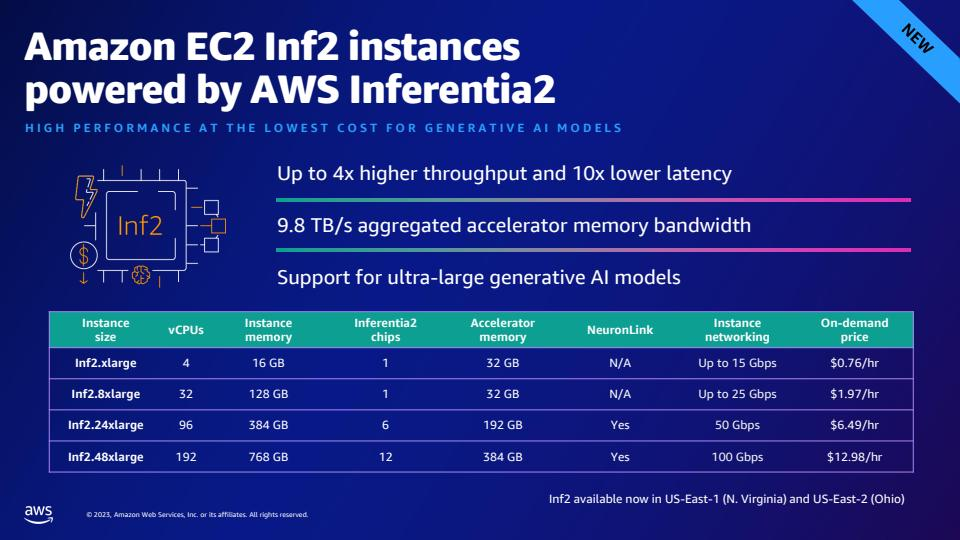

In [11]:
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
Image(filename=local_img_path) 

In [12]:
slide_text = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('slide_text')
print(slide_text)

The slide presents details about Amazon EC2 Inf2 instances powered by AWS Inferentia2. The key features highlighted are up to 4x higher throughput, 10x lower latency, 9.8 TB/s aggregated accelerator memory bandwidth, and support for ultra-large generative AI models.

The slide includes a table with the following columns: Instance Type, vCPUs, Instance memory, Inferentia2 chips, Accelerator memory, NeuronLink, Instance networking, and On-demand price.

The table contains the following rows with corresponding details:

1. Inf2.large: 4 vCPUs, 16 GB instance memory, 1 Inferentia2 chip, 32 GB accelerator memory, N/A for NeuronLink, Up to 15 Gbps instance networking, and $0.76/hr on-demand price.

2. Inf2.8xlarge: 32 vCPUs, 128 GB instance memory, 1 Inferentia2 chip, 32 GB accelerator memory, N/A for NeuronLink, Up to 25 Gbps instance networking, and $1.97/hr on-demand price.

3. Inf2.24xlarge: 96 vCPUs, 384 GB instance memory, 6 Inferentia2 chips, 192 GB accelerator memory, Yes for NeuronL

In [13]:
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

Unfortunately, the summary does not provide specific performance numbers comparing Inf2 instances to comparable EC2 instances. The summary focuses on describing the key features and specifications of the different Inf2 instance types, but does not directly compare their performance to other EC2 instances. Without that comparative performance data in the summary, I cannot provide a concise numerical answer to how Inf2 compares in performance to comparable EC2 instances.


### Question 2

[2024-03-15 19:21:26,710] p31817 {base.py:259} INFO - POST https://dkubp87d98zgk2ir1t85.us-east-1.aoss.amazonaws.com:443/slides/_search [status:200 request:0.057s]
[2024-03-15 19:21:26,711] p31817 {1697326408.py:18} INFO - received response from OpenSearch, response={
  "took": 16,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 13,
      "relation": "eq"
    },
    "max_score": 0.010257551,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3APjuBQ44BnnwpABaA9rnv",
        "_score": 0.010257551,
        "_source": {
          "image_path": "s3://multimodal-bucket-563851014557/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_27.jpg",
          "slide_text": "The slide titled 'Full stack AI/ML integration' provides an overview of Amazon Web Services (AWS) offerings for accelerated compute, frameworks and services, storage, and networking in the cont

download: s3://multimodal-bucket-563851014557/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_27.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_27.jpg


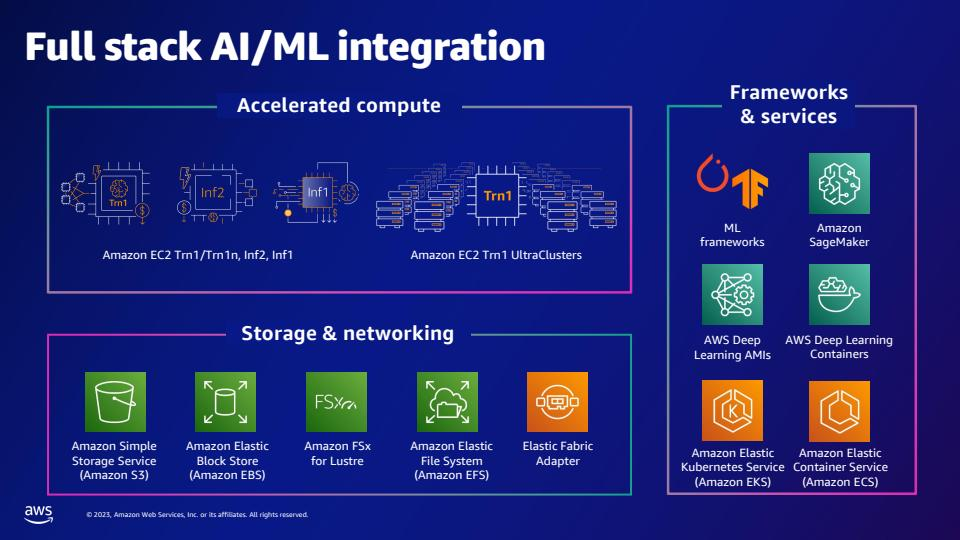

The summary does not provide any information about what AWS AI/ML services provide as per the AI/ML flywheel. It only discusses details about the Amazon EC2 Inf2 instances powered by AWS Inferentia2 chips. I do not have enough information to provide a concise answer to the question based on this summary.


In [14]:
# create prompt and convert to embeddings
question: str = "As per the AI/ML flywheel, what do the AWS AI/ML services provide?"
text_embedding = get_text_embedding(bedrock, question)

# vector db search
vector_db_response: Dict = find_similar_data(text_embedding)

# download image for local notebook display
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
display(Image(filename=local_img_path))

# Ask Claude
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

### Question 3

What about slides that contain charts and graphs? We want to see if the LLaVA model can correcly analyze a graph and pull appropriate metrics from the slide. 

[2024-03-15 19:21:30,973] p31817 {base.py:259} INFO - POST https://dkubp87d98zgk2ir1t85.us-east-1.aoss.amazonaws.com:443/slides/_search [status:200 request:0.037s]
[2024-03-15 19:21:30,975] p31817 {1697326408.py:18} INFO - received response from OpenSearch, response={
  "took": 18,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 13,
      "relation": "eq"
    },
    "max_score": 0.0047556455,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3ASzuGQ44BnnwpABaAkbmx",
        "_score": 0.0047556455,
        "_source": {
          "image_path": "s3://multimodal-bucket-563851014557/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_13.jpg",
          "slide_text": "The slide is titled 'AI models are getting bigger' with a subtitle '... A LOT BIGGER'.\n\nThe main content of the slide is a line chart showing the growth in model size, measured by the numbe

download: s3://multimodal-bucket-563851014557/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_13.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_13.jpg


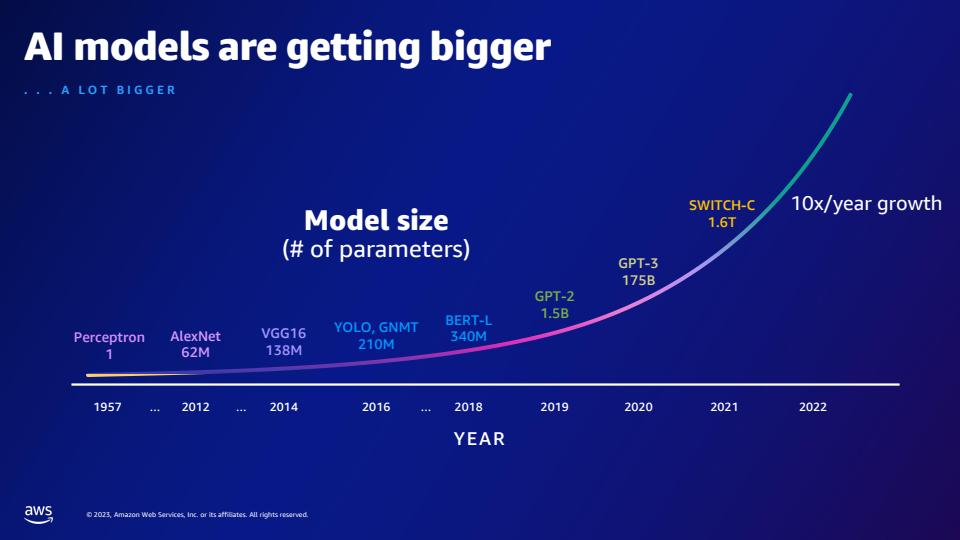

I don't have enough information in the given summary to answer how many more parameters GPT-3 has compared to GPT-2 or the numerical difference between their parameter sizes. The summary appears to be about Amazon EC2 Inf2 instances and does not mention GPT-2 or GPT-3 model parameters.


In [15]:
# create prompt and convert to embeddings
question: str = "Compared to GPT-2, how many more parameters does GPT-3 have? What is the numerical difference between the parameter size of GPT-2 and GPT-3?"
text_embedding = get_text_embedding(bedrock, question)

# vector db search
vector_db_response: Dict = find_similar_data(text_embedding)

# download image for local notebook display
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
display(Image(filename=local_img_path))

# Ask Claude
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

### Question 4

How about a question that cannot be answered based on this slide deck? We want to confirm that while some slide image will be retrieved but the Claude model does not hallucinate and correctly says  "I do not know".

[2024-03-15 19:21:35,717] p31817 {base.py:259} INFO - POST https://dkubp87d98zgk2ir1t85.us-east-1.aoss.amazonaws.com:443/slides/_search [status:200 request:0.037s]
[2024-03-15 19:21:35,718] p31817 {1697326408.py:18} INFO - received response from OpenSearch, response={
  "took": 14,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 13,
      "relation": "eq"
    },
    "max_score": 0.0022416236,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3ARDuDQ44BnnwpABaAzrme",
        "_score": 0.0022416236,
        "_source": {
          "image_path": "s3://multimodal-bucket-563851014557/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_6.jpg",
          "slide_text": "The slide titled 'The road to generative AI' presents a visual representation of different components and technologies that contribute to the development of generative AI.\n\nAt the center, th

download: s3://multimodal-bucket-563851014557/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_6.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_6.jpg


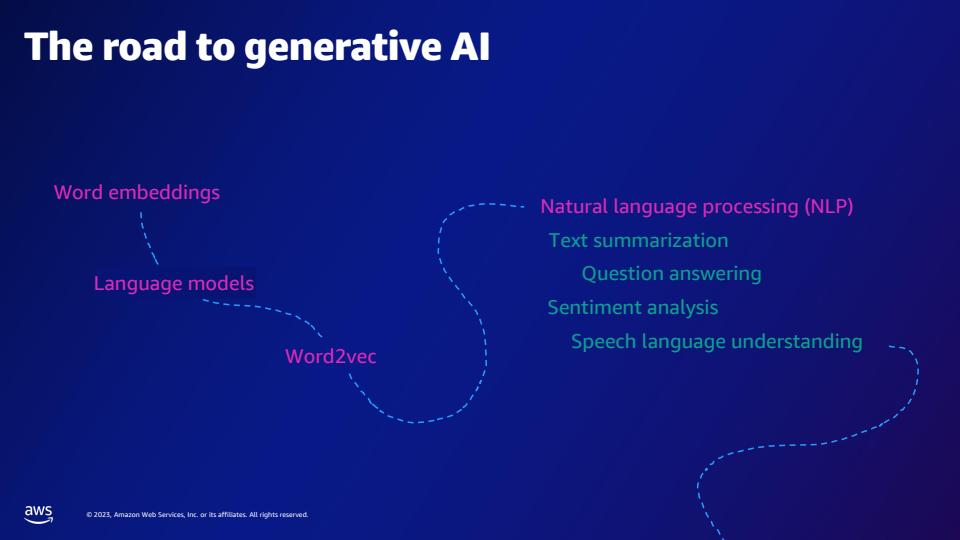

I don't know what quarks in particle physics are based on the provided summary, which discusses details about Amazon EC2 Inf2 instances powered by AWS Inferentia2. The summary does not contain any information related to quarks or particle physics.


In [16]:
# create prompt and convert to embeddings
question: str = "What are quarks in particle physics?"
text_embedding = get_text_embedding(bedrock, question)

# vector db search
vector_db_response: Dict = find_similar_data(text_embedding)

# download image for local notebook display
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
display(Image(filename=local_img_path))

# Ask Claude
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

## Clean Up
